In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pysankey2 import Sankey
import matplotlib as mpl
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [4]:
from cluster import reindex_clusters

In [57]:
df_cluster_def = pd.read_pickle('../data/clustering/cluster_definitions.pkl')
df_cluster_dat = pd.read_pickle('../data/clustering/cluster_membership.pkl')
df_similarity = pd.read_pickle('../data/clustering/similarity.pkl')

da = ['dataset', 'atlas']
combos = df_cluster_def.value_counts(da).index
sliced_da = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]

In [80]:
cluster_orders = {}

get_signatures = lambda df, c: [np.reshape(_, -1) for _ in sliced_da(df, *c)['signature']]

c1 = combos[0]
s1 = get_signatures(df_cluster_def, c1)
nc1 = len(s1)

cluster_orders[c1[1]] = np.arange(nc1)

In [91]:
for idx, c2 in enumerate(combos[1:]):
    s2 = get_signatures(df_cluster_def, c2)
    nc2 = len(s2)
    ts = np.stack(s1 + s2)
    
    ts_sim = np.corrcoef(ts)
    mval = np.min(ts_sim)

    ts_sim[0:nc1, 0:nc1] = mval
    ts_sim[nc1:nc1+nc2, nc1:nc1+nc2] = mval

    locs = []

    for _ in range(min([nc1, nc2])):
        l = np.argmax(ts_sim[_, :])
        ts_sim[l,:] = mval
        ts_sim[:,l] = mval
        ts_sim[_,l] = 1
        ts_sim[l,_] = 1
        locs += [l - nc1]

    cluster_orders[c2[1]] = np.argsort(locs)

cluster_orders

{'hox': array([0, 1, 2, 3, 4, 5]),
 'cc2': array([0, 3, 2, 1, 4]),
 'aal': array([1, 0, 2, 3]),
 'des': array([1, 0, 3, 2])}

In [84]:
cois = ['subject', 'session', 'dataset']
df_clust = df_similarity[cois].groupby(['subject', 'session']).max()

for idx, row in df_cluster_dat.iterrows():
    k = tuple(row[['dataset', 'atlas']])
    v = row['labels']
    df_clust[k[1]] = reindex_clusters(v, order=cluster_orders[k[1]])

df_clust

dataset  aal  cc2  des  hox
subject session                            
0025921 1          BNU2    0    0    0    0
        2          BNU2    0    0    1    2
0025922 1          BNU2    0    3    1    1
        2          BNU2    0    0    1    0
0025923 1          BNU2    2    0    2    0
...                 ...  ...  ...  ...  ...
0025968 2          BNU2    3    3    1    3
0025969 1          BNU2    2    1    1    2
        2          BNU2    2    0    3    0
0025970 1          BNU2    1    3    1    2
        2          BNU2    1    3    1    1

[100 rows x 5 columns]

In [85]:
nc = np.max([len(_) for _ in cluster_orders.values()])

In [89]:
cm = mpl.cm.get_cmap('Dark2').colors

atlas = 'BNU1'
order = ['aal', 'cc2', 'hox', 'des']
col_names = {p: 'layer'+str(_+1) for _, p in enumerate(order)}
cords = {'layer'+str(_+1): np.arange(len(cluster_orders[p])) for _, p in enumerate(order)}

dfc2 = df_clust[order]
dfc2 = dfc2.rename(columns=col_names)
dfc2 = dfc2.reset_index().drop(columns=['subject', 'session'])

nc = np.max([len(_) for _ in cluster_orders.values()])
color_dict = {_: cm[_] for _ in range(nc)}

# cords = {"layer{0}".format(_+1): list(range(len(v)))
        #  for _, (k, v) in enumerate(cluster_orders.items())}

dfc2, cords

(    layer1  layer2  layer3  layer4
 0        0       0       0       0
 1        0       0       2       1
 2        0       3       1       1
 3        0       0       0       1
 4        2       0       0       2
 ..     ...     ...     ...     ...
 95       3       3       3       1
 96       2       1       2       1
 97       2       0       0       3
 98       1       3       2       1
 99       1       3       1       1
 
 [100 rows x 4 columns],
 {'layer1': array([0, 1, 2, 3]),
  'layer2': array([0, 1, 2, 3, 4]),
  'layer3': array([0, 1, 2, 3, 4, 5]),
  'layer4': array([0, 1, 2, 3])})

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

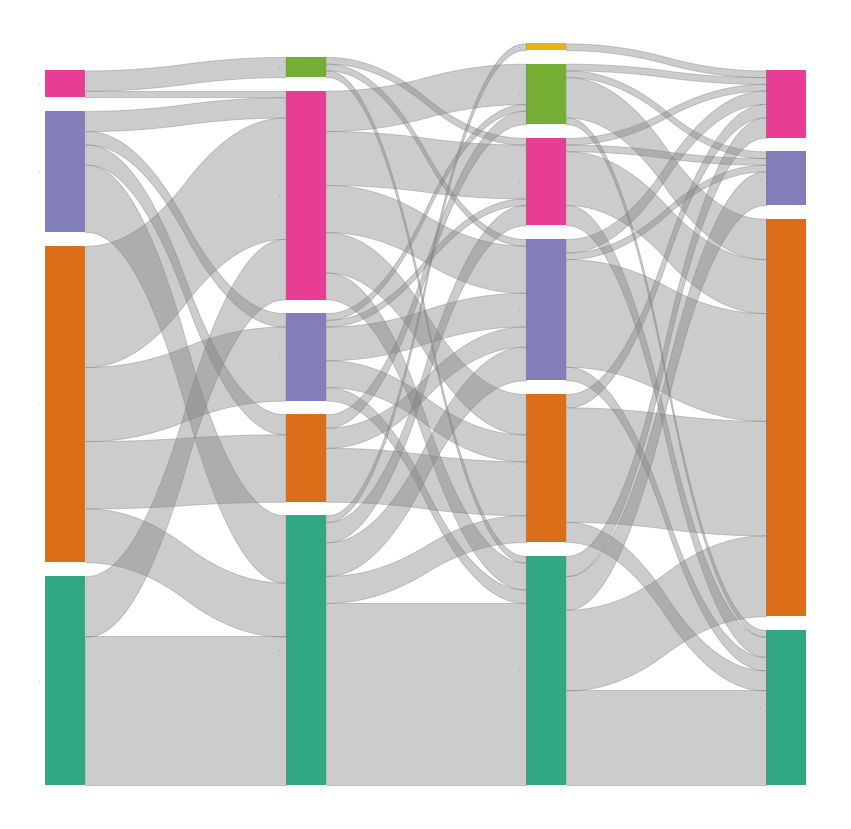

In [90]:
subject_clustering = Sankey(dfc2, colorMode='global', stripColor='gray',
                            colorDict= color_dict, layerLabels=cords)

subject_clustering.plot(figSize=(15, 15), fontSize=0)

In [92]:
for idx, c1 in enumerate(combos):
    for jdx, c2 in enumerate(combos[idx+1:]):
        print(c1[1], c2[1])
        l1 = labels[c1]
        l2 = labels[c2]
        
#         print(adjusted_mutual_info_score(l1, l2))
        print(adjusted_rand_score(l1, l2))
        tmp = l1 == l2
        print(np.sum(tmp)/len(tmp))

hox cc2


NameError: name 'labels' is not defined